# Getting the Data

In [1]:
def read_data(path):
    import pandas as pd
    import pendulum
    df_logins = pd.read_parquet(path+'/logins.parquet')
    df_payments = pd.read_parquet(path+'/payments.parquet')

    df_payments["datetime"] = pd.to_datetime(df_payments.timestamp, unit='ms')
    df_payments["date"] = df_payments.datetime.dt.date
    df_payments["hour"] = df_payments.datetime.apply(lambda x: x.hour)
    df_payments["week"] = df_payments.datetime.apply(lambda x: x.hour)
    df_payments["month"] = df_payments.datetime.apply(lambda x: x.month)
    df_payments["week_of_month"] = df_payments.datetime.apply(lambda x: pendulum.instance(x).week_of_month)

    df_payments["weekday"] = df_payments.datetime.apply(lambda x: x.weekday())
    df_payments["day_of_week"] = df_payments.datetime.apply(lambda x: x.day_name())
    df_payments["week"] = df_payments.datetime.apply(lambda x: 'Workday' if x.weekday() < 5 else 'Weekend')

    df_payments['chargedback'] = df_payments.chargedback.apply(lambda x: 1 if x else 0)
    df_payments['signal'] = df_payments.chargedback.apply(lambda x: 'SIGNAL' if x else 'NON_SIGNAL')

    df_payments['total_payments_account'] = df_payments.groupby('account_id')['id'].transform('nunique')
    df_payments['total_accounts_device'] = df_payments.groupby('device_id')['account_id'].transform('nunique')
    df_payments['total_installation_device'] = df_payments.groupby('device_id')['installation_id'].transform('nunique')
    df_payments['total_value_account'] = df_payments.groupby('account_id')['value'].transform('sum')

    return df_logins, df_payments

In [2]:
from pycaret.datasets import get_data

_, df_payments = read_data('../../src/data')

In [3]:
dataset = df_payments
dataset.head()

,id,account_id,device_id,installation_id,timestamp,device_age_ms,n_accounts_by_device_30d,value,sum_values_by_device_30d,sum_values_by_device_3d,...,week,month,week_of_month,weekday,day_of_week,signal,total_payments_account,total_accounts_device,total_installation_device,total_value_account
0,103262188752,Qg1D8ImiasT1avXL,7MkfhkrM5b0zCXzO,MR8p/uS6dEX1KlLX,1628347177114,6.145809e+09,1.0,111.781008,NaN,NaN,...,Weekend,8,2,5,Saturday,NON_SIGNAL,1,1,1,111.781008
1,103262188753,7oDcXhI2gc9IY/O2,64aUkvZXE0l7rRYB,lkZEByfr7JB81M0z,1631746300532,9.177266e+09,1.0,137.111008,2602.661008,92.811008,...,Workday,9,3,2,Wednesday,NON_SIGNAL,100,1,1,7554.130780
2,103262188754,yCnksj2py9afMuyJ,j9MxfU8zaJSBAJJB,KwB8eOTyu/c1X/vo,1625328607782,1.192803e+10,0.0,145.601008,0.000000,0.000000,...,Weekend,7,1,5,Saturday,NON_SIGNAL,7,1,1,1093.817055
3,103262188755,UdU8Tz5Vaqw4wpCH,GgWDCBqCa09125xz,/7CONsK63eeDR+bg,1626373613876,4.149963e+09,NaN,85.141008,NaN,NaN,...,Workday,7,3,3,Thursday,NON_SIGNAL,12,31281,31976,1006.322094
4,103262188756,zwb2WB1zI75ku8Z0,Hulxshcopdyf7gaA,qrvdkJ49Ej/kCgdu,1625593458071,1.558110e+08,1.0,189.251008,NaN,NaN,...,Workday,7,2,1,Tuesday,NON_SIGNAL,3,1,1,759.143023


In [4]:
dataset.shape

(648173, 29)

In [5]:
TARGET = 'chargedback'
NUMERIC_FEA = ['device_age_ms', 'n_accounts_by_device_30d', 'value', 'sum_values_by_device_30d',
'sum_values_by_device_3d', 'sum_values_by_installation_30d', 'sum_values_by_installation_3d',
'low_geo_chargeback_rate_30d', 'medium_geo_chargeback_rate_30d', 'high_geo_chargeback_rate_30d'
]
IGNORE_FEA  = set(dataset.columns)-set(NUMERIC_FEA)-set([TARGET])

print(NUMERIC_FEA)

['device_age_ms', 'n_accounts_by_device_30d', 'value', 'sum_values_by_device_30d', 'sum_values_by_device_3d', 'sum_values_by_installation_30d', 'sum_values_by_installation_3d', 'low_geo_chargeback_rate_30d', 'medium_geo_chargeback_rate_30d', 'high_geo_chargeback_rate_30d']


In [6]:
data = dataset.sample(frac=0.80, random_state=786)
data_unseen = dataset.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (518538, 29)
Unseen Data For Predictions: (129635, 29)


# Initializing Setup

In [7]:
from pycaret.classification import *

In [8]:
exp_clf101 = setup(data = data,
                   target = TARGET,
                   numeric_features=NUMERIC_FEA,
                   ignore_features=IGNORE_FEA,
                   session_id = 123,
                   log_plots=False,
                   use_gpu = True,
                   )

,Description,Value
0,Session id,123
1,Target,chargedback
2,Target type,Binary
3,Original data shape,"(518538, 29)"
4,Transformed data shape,"(518538, 11)"
5,Transformed train set shape,"(362976, 11)"
6,Transformed test set shape,"(155562, 11)"
7,Ignore features,18
8,Numeric features,10
9,Rows with missing values,38.4%


[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


In [9]:
models()

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


# Compare Models

In [10]:
best_model = compare_models(sort='Recall')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.9698,0.8976,0.5035,0.0852,0.1457,0.1381,0.1982,0.3000
lda,Linear Discriminant Analysis,0.9868,0.9216,0.3923,0.1659,0.2332,0.2276,0.2494,0.5290
dt,Decision Tree Classifier,0.9920,0.6260,0.2563,0.2363,0.2457,0.2417,0.2420,2.7500
et,Extra Trees Classifier,0.9949,0.8783,0.2142,0.5111,0.3017,0.2996,0.3287,3.2990
rf,Random Forest Classifier,0.9951,0.9100,0.1408,0.5686,0.2253,0.2237,0.2809,6.1780
xgboost,Extreme Gradient Boosting,0.9950,0.9532,0.1004,0.5427,0.1688,0.1674,0.2311,0.7860
lightgbm,Light Gradient Boosting Machine,0.9932,0.9375,0.0848,0.1703,0.1126,0.1096,0.1166,18.6980
ada,Ada Boost Classifier,0.9944,0.9446,0.0631,0.2811,0.1026,0.1008,0.1306,12.4760
catboost,CatBoost Classifier,0.9950,0.9519,0.0534,0.5729,0.0975,0.0967,0.1732,4.0950
gbc,Gradient Boosting Classifier,0.9948,0.9418,0.0275,0.4313,0.0513,0.0507,0.1056,58.6310


In [11]:
print(best_model)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)


# Create Model

In [12]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9953,0.9164,0.1676,0.6739,0.2684,0.2669,0.3346
1,0.9947,0.8979,0.1027,0.4130,0.1645,0.1628,0.2041
2,0.9948,0.8966,0.0973,0.4615,0.1607,0.1592,0.2102
3,0.9950,0.8976,0.1075,0.5556,0.1802,0.1788,0.2429
4,0.9951,0.9263,0.1667,0.5849,0.2594,0.2577,0.3105
5,0.9952,0.8877,0.1667,0.5962,0.2605,0.2588,0.3135
6,0.9951,0.9262,0.1297,0.5854,0.2124,0.2109,0.2740
7,0.9953,0.9188,0.1568,0.6444,0.2522,0.2507,0.3163
8,0.9952,0.9243,0.1622,0.5882,0.2542,0.2526,0.3072


In [13]:
dt = create_model('dt')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9922,0.6277,0.2595,0.2487,0.2540,0.2501,0.2501
1,0.9913,0.6138,0.2324,0.2000,0.2150,0.2107,0.2113
2,0.9916,0.6005,0.2054,0.1939,0.1995,0.1953,0.1953
3,0.9926,0.6406,0.2849,0.2789,0.2819,0.2782,0.2782
4,0.9923,0.6538,0.3118,0.2788,0.2944,0.2906,0.2910
5,0.9921,0.6243,0.2527,0.2435,0.2480,0.2441,0.2441
6,0.9919,0.6222,0.2486,0.2300,0.2390,0.2349,0.2351
7,0.9921,0.6196,0.2432,0.2356,0.2394,0.2354,0.2354
8,0.9913,0.6219,0.2486,0.2063,0.2255,0.2212,0.2221


In [14]:
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9938,0.9397,0.0919,0.2329,0.1318,0.1293,0.1436
1,0.9926,0.9288,0.1135,0.1680,0.1355,0.1319,0.1345
2,0.9934,0.9513,0.0703,0.1625,0.0981,0.0953,0.1039
3,0.9928,0.9492,0.0430,0.0870,0.0576,0.0543,0.0578
4,0.9933,0.9389,0.0806,0.1744,0.1103,0.1074,0.1155
5,0.9933,0.9311,0.0699,0.1566,0.0967,0.0938,0.1016
6,0.9934,0.9131,0.1297,0.2308,0.1661,0.1630,0.1699
7,0.9934,0.9338,0.1135,0.2188,0.1495,0.1465,0.1545
8,0.9931,0.9418,0.0649,0.1319,0.0870,0.0839,0.0893


In [15]:
xgb = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9952,0.9535,0.1297,0.6667,0.2172,0.2159,0.2927
1,0.9948,0.9492,0.0757,0.4242,0.1284,0.1271,0.1776
2,0.9948,0.9544,0.0703,0.4643,0.1221,0.1209,0.1792
3,0.9951,0.9604,0.0914,0.6538,0.1604,0.1593,0.2433
4,0.9950,0.9501,0.1129,0.5385,0.1867,0.1852,0.2450
5,0.9950,0.9549,0.1075,0.5405,0.1794,0.1780,0.2395
6,0.9950,0.9439,0.0865,0.5714,0.1502,0.1491,0.2210
7,0.9950,0.9570,0.1135,0.5250,0.1867,0.1852,0.2425
8,0.9950,0.9539,0.0919,0.5312,0.1567,0.1554,0.2195


In [16]:
qda = create_model('qda')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9699,0.9180,0.5568,0.0925,0.1587,0.1513,0.2184
1,0.9696,0.8953,0.4541,0.0774,0.1323,0.1247,0.1783
2,0.9704,0.9002,0.4757,0.0827,0.1409,0.1334,0.1894
3,0.9702,0.8941,0.5269,0.0897,0.1534,0.1459,0.2087
4,0.9683,0.8800,0.5000,0.0807,0.1390,0.1313,0.1917
5,0.9703,0.9125,0.5108,0.0877,0.1497,0.1422,0.2029
6,0.9697,0.8705,0.4162,0.0720,0.1227,0.1150,0.1637
7,0.9715,0.9076,0.5892,0.1020,0.1738,0.1666,0.2370
8,0.9699,0.9065,0.5135,0.0866,0.1482,0.1407,0.2021


# Tune Model

In [17]:
tuned_rf = tune_model(rf, optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8705,0.9501,0.8865,0.0339,0.0652,0.0560,0.1585
1,0.8728,0.9393,0.8865,0.0345,0.0663,0.0571,0.1602
2,0.8769,0.9436,0.8757,0.0351,0.0676,0.0584,0.1609
3,0.8768,0.9516,0.8925,0.0359,0.0691,0.0598,0.1648
4,0.8739,0.9376,0.8656,0.0342,0.0657,0.0564,0.1571
5,0.8732,0.9463,0.8978,0.0351,0.0676,0.0584,0.1632
6,0.8777,0.9292,0.8541,0.0346,0.0665,0.0572,0.1571
7,0.8708,0.9411,0.8865,0.0339,0.0654,0.0561,0.1587
8,0.8784,0.9552,0.8865,0.0360,0.0692,0.0600,0.1644


In [18]:
tuned_dt = tune_model(dt, optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9947,0.7808,0.1189,0.4314,0.1864,0.1846,0.2245
1,0.9940,0.8040,0.1243,0.2875,0.1736,0.1710,0.1864
2,0.9942,0.7647,0.1027,0.2969,0.1526,0.1504,0.1722
3,0.9947,0.8357,0.1344,0.4310,0.2049,0.2030,0.2386
4,0.9943,0.7943,0.0914,0.3091,0.1411,0.1391,0.1658
5,0.9940,0.7602,0.1237,0.2949,0.1742,0.1717,0.1883
6,0.9945,0.8094,0.1135,0.3684,0.1736,0.1716,0.2023
7,0.9943,0.7996,0.1351,0.3472,0.1946,0.1922,0.2142
8,0.9945,0.8056,0.0865,0.3333,0.1373,0.1355,0.1677


In [19]:
tuned_lgbm = tune_model(lgbm, optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9904,0.7782,0.2162,0.1646,0.1869,0.1822,0.1839
1,0.9879,0.7734,0.1405,0.0844,0.1055,0.0997,0.1030
2,0.9847,0.8010,0.1838,0.0778,0.1093,0.1029,0.1127
3,0.9896,0.8518,0.1667,0.1216,0.1406,0.1355,0.1372
4,0.9898,0.7779,0.1720,0.1290,0.1475,0.1424,0.1439
5,0.9899,0.8360,0.1613,0.1255,0.1412,0.1362,0.1373
6,0.9904,0.8734,0.1892,0.1489,0.1667,0.1619,0.1631
7,0.9890,0.7962,0.2541,0.1516,0.1899,0.1847,0.1910
8,0.9748,0.8228,0.1784,0.0414,0.0672,0.0594,0.0764


In [20]:
tuned_xgb = tune_model(xgb, optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9488,0.9371,0.7243,0.0690,0.1259,0.1177,0.2133
1,0.9320,0.9275,0.7568,0.0546,0.1019,0.0933,0.1917
2,0.9478,0.9312,0.7027,0.0660,0.1206,0.1124,0.2049
3,0.9492,0.9431,0.7473,0.0718,0.1311,0.1229,0.2217
4,0.9487,0.9117,0.6828,0.0658,0.1200,0.1117,0.2013
5,0.9491,0.9287,0.6935,0.0672,0.1225,0.1142,0.2054
6,0.9498,0.9083,0.7027,0.0685,0.1249,0.1167,0.2092
7,0.9477,0.9303,0.7784,0.0719,0.1316,0.1234,0.2267
8,0.9461,0.9460,0.7459,0.0674,0.1237,0.1154,0.2140


In [21]:
tuned_qda = tune_model(qda, optimize = 'Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8286,0.8585,0.7351,0.0216,0.0419,0.0323,0.1060
1,0.8325,0.8332,0.7027,0.0211,0.0410,0.0314,0.1017
2,0.8353,0.8364,0.7081,0.0216,0.0420,0.0324,0.1039
3,0.8348,0.8174,0.6505,0.0200,0.0388,0.0291,0.0931
4,0.8337,0.8082,0.6613,0.0202,0.0391,0.0295,0.0947
5,0.8294,0.8504,0.7419,0.0220,0.0427,0.0330,0.1079
6,0.8315,0.8090,0.6595,0.0198,0.0384,0.0288,0.0932
7,0.8258,0.8401,0.7243,0.0209,0.0407,0.0311,0.1029
8,0.8300,0.8236,0.6973,0.0207,0.0401,0.0305,0.0996


# Plot Model

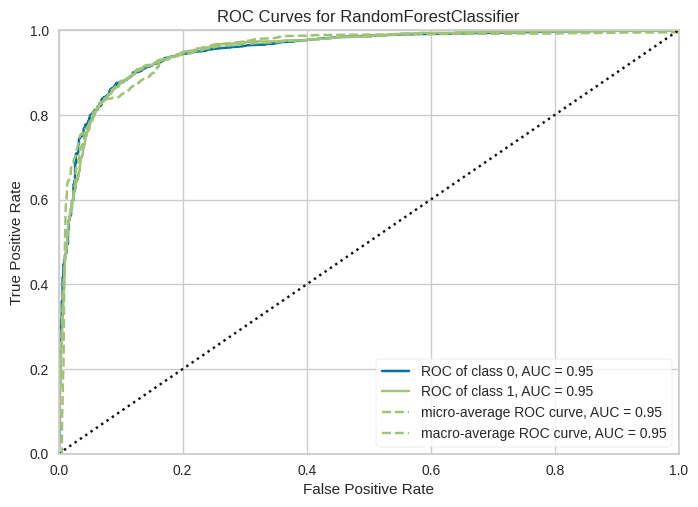

In [22]:
plot_model(tuned_rf, plot = 'auc')

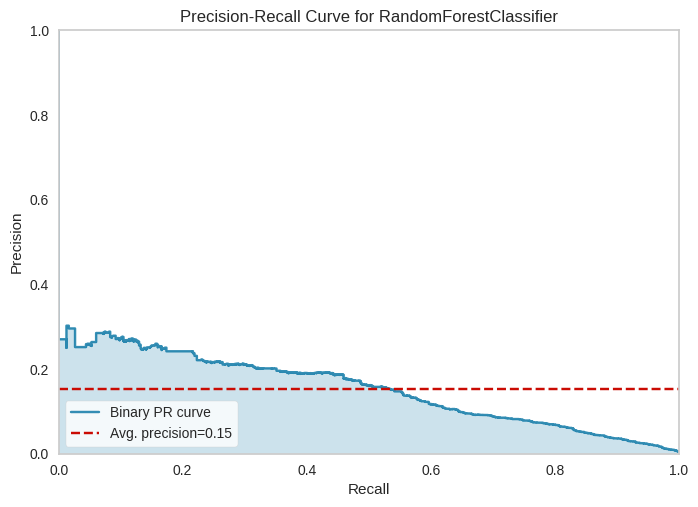

In [23]:
plot_model(tuned_rf, plot = 'pr')

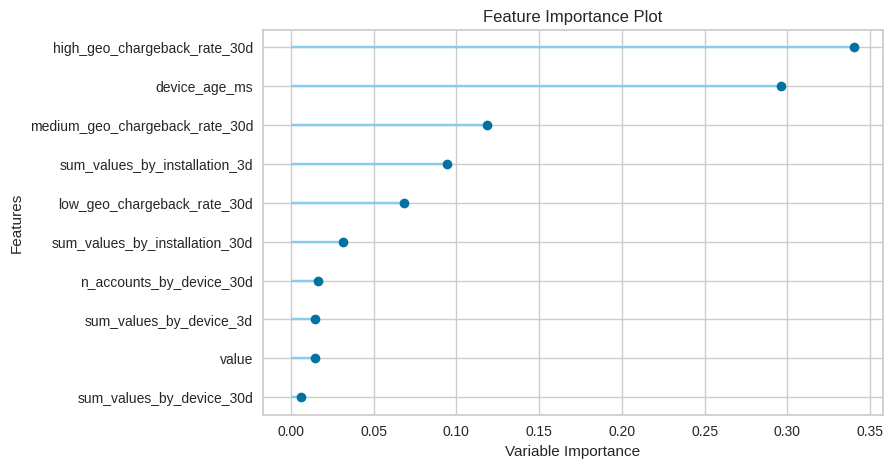

In [24]:
plot_model(tuned_rf, plot='feature')

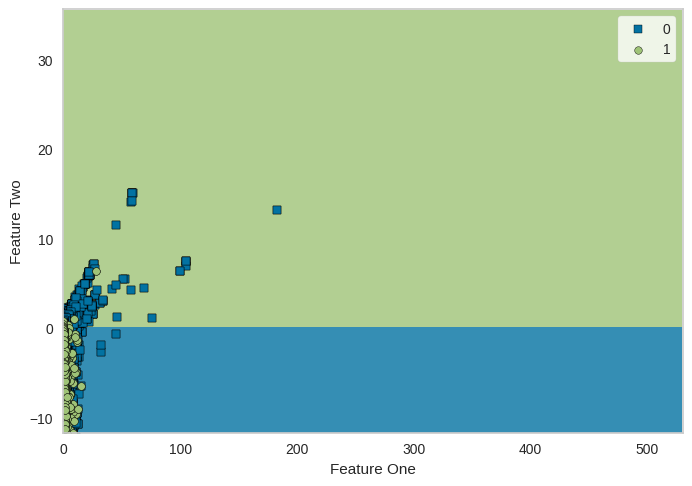

In [25]:
plot_model(tuned_rf, plot='boundary')

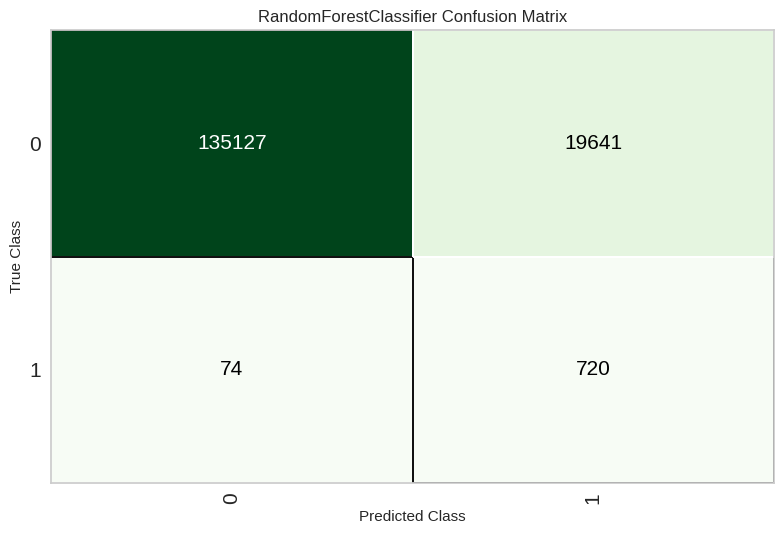

In [26]:
plot_model(tuned_rf, plot = 'confusion_matrix')

# Predict on test / hold-out Sample

In [27]:
pred_holdout = predict_model(tuned_rf)
pred_holdout.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8733,0.9515,0.9068,0.0354,0.0681,0.0588,0.1648


,device_age_ms,n_accounts_by_device_30d,value,sum_values_by_device_30d,sum_values_by_device_3d,sum_values_by_installation_30d,sum_values_by_installation_3d,low_geo_chargeback_rate_30d,medium_geo_chargeback_rate_30d,high_geo_chargeback_rate_30d,chargedback,prediction_label,prediction_score
362976,1.422844e+10,1.0,39.511009,2545.720947,493.161011,2545.720947,493.161011,0.009453,0.0,0.0,0,0,0.8625
362977,1.244212e+10,1.0,65.831009,3401.510986,467.701019,3401.510986,467.701019,0.000957,0.0,0.0,0,0,0.9264
362978,9.048879e+09,1.0,170.201004,1539.801025,280.111023,1539.801025,280.111023,0.053407,0.0,0.0,0,0,0.8454
362979,1.183314e+10,1.0,53.341007,236.151001,0.000000,236.151001,0.000000,0.000000,0.0,0.0,0,0,0.9386
362980,1.440747e+10,1.0,110.931007,1987.211060,505.721008,1987.211060,505.721008,0.000000,0.0,0.0,0,0,0.9261


# Finalize Model

In [28]:
final_rf = finalize_model(tuned_rf)

In [29]:
print(final_rf)

Pipeline(memory=Memory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['device_age_ms',
                                             'n_accounts_by_device_30d',
                                             'value',
                                             'sum_values_by_device_30d',
                                             'sum_values_by_device_3d',
                                             'sum_values_by_installation_30d',
                                             'sum_values_by_installation_3d',
                                             'low_geo_chargeback_rate_30d',
                                             'medium_geo_chargeback_rate_30d',
                                             'hig...
                 RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                                        class_weight='balanced_subsample',
                    

# Predict on unseen data

In [30]:
data_unseen.head()

,id,account_id,device_id,installation_id,timestamp,device_age_ms,n_accounts_by_device_30d,value,sum_values_by_device_30d,sum_values_by_device_3d,...,week,month,week_of_month,weekday,day_of_week,signal,total_payments_account,total_accounts_device,total_installation_device,total_value_account
0,103262188757,hodIaEnnqFqEqcY/,XcUQAPZo30oD1/oQ,27WE+mzescXK/yzL,1629491917692,4.229986e+09,1.0,67.421008,1231.581008,0.000000,...,Workday,8,4,4,Friday,NON_SIGNAL,29,3,1,2733.249226
1,103262188760,ZlxdsvCderVz/uux,cRUeoEqkiIx9xF02,qhSEsGQdo1xP6lGB,1620052517751,4.256864e+07,6.0,38.491008,1030.601008,718.151008,...,Workday,5,2,0,Monday,NON_SIGNAL,4,45,5,251.334031
2,103262188766,OAuTI2A3TE+pFfdu,S/tJmfFHLUgdWnce,b/hjfWmLlVjG2/Qt,1625486795106,1.237738e+10,1.0,70.291008,547.041008,0.000000,...,Workday,7,2,0,Monday,NON_SIGNAL,25,1,1,3155.245195
3,103262188767,wK68iCTaFAxEDy68,GgWDCBqCa09125xz,EYUpOEYhQRui96OZ,1631179981651,9.523851e+09,NaN,57.161008,NaN,NaN,...,Workday,9,2,3,Thursday,NON_SIGNAL,10,31281,31976,705.070078
4,103262188770,5lcc1E7My+p8EGez,2W9pwtAAM68JR5Xx,W89dcqW4R9lfyBjB,1630587794823,1.734079e+10,1.0,106.231008,1407.481008,0.000000,...,Workday,9,1,3,Thursday,NON_SIGNAL,51,1,1,6253.881398


In [31]:
data_unseen.drop('chargedback', axis = 1, inplace = True)

In [32]:
pred_unseen = predict_model(final_rf, data=data_unseen)
pred_unseen.head()

,device_age_ms,n_accounts_by_device_30d,value,sum_values_by_device_30d,sum_values_by_device_3d,sum_values_by_installation_30d,sum_values_by_installation_3d,low_geo_chargeback_rate_30d,medium_geo_chargeback_rate_30d,high_geo_chargeback_rate_30d,prediction_label,prediction_score
0,4.229986e+09,1.0,67.421005,1231.581055,0.000000,1231.581055,0.0,0.000000,0.000000,0.00000,0,0.9238
1,4.256864e+07,6.0,38.491009,1030.600952,718.151001,NaN,NaN,0.013331,0.025031,0.31451,1,0.9441
2,1.237738e+10,1.0,70.291008,547.041016,0.000000,547.041016,0.0,0.001068,0.000000,0.00000,0,0.9397
3,9.523850e+09,NaN,57.161007,NaN,NaN,322.181000,0.0,0.001067,0.000000,0.00000,0,0.9235
4,1.734079e+10,1.0,106.231010,1407.480957,0.000000,1407.480957,0.0,0.000000,0.000000,0.00000,0,0.9405


# Save Model

In [33]:
save_model(final_rf,'solution_1')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['device_age_ms',
                                              'n_accounts_by_device_30d',
                                              'value',
                                              'sum_values_by_device_30d',
                                              'sum_values_by_device_3d',
                                              'sum_values_by_installation_30d',
                                              'sum_values_by_installation_3d',
                                              'low_geo_chargeback_rate_30d',
                                              'medium_geo_chargeback_rate_30d',
                                              'hig...
                  RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                                         class_weight='balanced_subsample',
     

# Load Model

In [34]:
rf_pipeline_from_disk = load_model('solution_1')

Transformation Pipeline and Model Successfully Loaded


In [35]:
new_prediction = predict_model(rf_pipeline_from_disk, data=data_unseen)
new_prediction.head()

,device_age_ms,n_accounts_by_device_30d,value,sum_values_by_device_30d,sum_values_by_device_3d,sum_values_by_installation_30d,sum_values_by_installation_3d,low_geo_chargeback_rate_30d,medium_geo_chargeback_rate_30d,high_geo_chargeback_rate_30d,prediction_label,prediction_score
0,4.229986e+09,1.0,67.421005,1231.581055,0.000000,1231.581055,0.0,0.000000,0.000000,0.00000,0,0.9238
1,4.256864e+07,6.0,38.491009,1030.600952,718.151001,NaN,NaN,0.013331,0.025031,0.31451,1,0.9441
2,1.237738e+10,1.0,70.291008,547.041016,0.000000,547.041016,0.0,0.001068,0.000000,0.00000,0,0.9397
3,9.523850e+09,NaN,57.161007,NaN,NaN,322.181000,0.0,0.001067,0.000000,0.00000,0,0.9235
4,1.734079e+10,1.0,106.231010,1407.480957,0.000000,1407.480957,0.0,0.000000,0.000000,0.00000,0,0.9405
